In [81]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

from fringes import fringe_wrapper
from config import config
from phase1 import phase_wrapper, PE

rmse = lambda diff: np.sqrt(np.nanmean(diff ** 2))
dist = lambda points: np.sqrt(np.sum(points**2, axis=-1))

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
end_header
'''
def write_ply(fn, verts):
    verts = verts[:,20:-20,:]
    verts = verts.reshape(-1, 3)
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f')
        
def recons3d(disparity):
    h, w = disparity.shape[0:2]
    f = 5.0*w                          # artificial focal length                      
    Q = np.float32([[5, 0, 0, -0.5*w],
                    [0,-5, 0,  0.5*h], # turn points 180 deg around x-axis,
                    [0, 0, 0,     -f], # so that y-axis looks up
                    [0, 0, 1,      0]])
    points = cv2.reprojectImageTo3D(disparity.astype(np.float32), Q)
    return points

methods = ["PE", "MPE", "LLS", "CFPE"]
linetypes = [":>", "--s", "-.<", "-o","-o"]

In [82]:
# config
cfg = config()
cfg.debug = False
cfg.pattern_size = [1920, 50]
cfg.Tp = [30, 33, 36]       #在这个实验中，就先设置成这个周期。

# Note that, we must update Tc and alpha for correct phase extraction
cfg.Tc = cfg.Tp # Tc is for camera recordings
cfg.alpha = [1, cfg.Tp[0]/cfg.Tp[1], cfg.Tp[0]/cfg.Tp[2]]

In [83]:
cfg.A = [128,128,128]
cfg.B = [100,100,100]
cfg.C, cfg.D, cfg.E , cfg.F= 5,4,3,2
def three_or_four_or_seven_step_manner_contract(cfg, noise_model):
    # generate the test images, ground truth of phase map and points
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()
    phase_truth = fringe_generator.generate_phase()
    point_truth = recons3d(phase_truth*0+88)

    # phase extraction and convert to 3d points
    phase_measures = PE(cfg).psi_extract(images=fringe_images[0])      # wrapped phase

    disparitys = (phase_measures - phase_truth) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures = recons3d(disparitys)

    # Performance evaluation
    rmse_phase = rmse(phase_measures[:, 20:-20] - phase_truth[:, 20:-20])
    rmse_point = rmse(dist(point_measures[:, 20:-20, :] - point_truth[:, 20:-20, :]))

    return rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures


cfg.gamma=1.3
noise_model = "gamma"
cfg.steps = [3,3,3]
rmse_phase1, rmse_point1, phase_truth1, point_truth1, phase_measures1, point_measures1 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
cfg.steps = [4,4,4]
rmse_phase2, rmse_point2, phase_truth2, point_truth2, phase_measures2, point_measures2 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
cfg.steps = [7,7,7]
rmse_phase3, rmse_point3, phase_truth3, point_truth3, phase_measures3, point_measures3 = three_or_four_or_seven_step_manner_contract(cfg,noise_model)
    
print(f"RMSE(phase1):{rmse_phase1}")
print(f"RMSE(point1):{rmse_point1}")
print(f"RMSE(phase2):{rmse_phase2}")
print(f"RMSE(point2):{rmse_point2}")
print(f"RMSE(phase3):{rmse_phase3}")
print(f"RMSE(point3):{rmse_point3}")

RMSE(phase1):228.06645555920917
RMSE(point1):649.3512573242188
RMSE(phase2):228.24909482292296
RMSE(point2):639.1505737304688
RMSE(phase3):228.24910214371184
RMSE(point3):639.07275390625


In [84]:
# # pitfall problem
# def case_study(cfg, noise_model):
#     # generate the test images, ground truth of phase map and points
#     fringe_generator = fringe_wrapper(cfg, noise_model)
#     fringe_images = fringe_generator.generate_all()
#     phase_truth = fringe_generator.generate_phase()
#     point_truth = recons3d(phase_truth*0+88)

#     # phase extraction and convert to 3d points
#     phase_measures = [phase_wrapper(cfg, m).psi_extract(fringe_images[0]) for m in methods]
#     disparitys = [(pm-phase_truth)*cfg.Tp[0]/(2*np.pi)+88 for pm in phase_measures]
#     point_measures = [recons3d(disp) for disp in disparitys]

#     # Performance evaluation
#     rmse_phase = [rmse(p[:,20:-20]- phase_truth[:,20:-20]) for p in phase_measures]
#     rmse_point = [rmse(dist(p[:,20:-20,:]- point_truth[:,20:-20,:])) for p in point_measures]
#     # print(phase_measures-phase_truth)
#     return rmse_phase, rmse_point, phase_truth, point_truth, phase_measures, point_measures

# cfg.steps = [3,3,3]
# cfg.MaxIter = 9
# rmse_phase4, rmse_point4, phase_truth4, point_truth4, phase_measures4, point_measures4 = case_study(cfg,noise_model)

进入MPSP方法
self.C :  tensor([[ 0.8019,  0.3569,  0.3569,  0.8019],
        [ 1.0000,  1.4450, -0.8019, -0.8019],
        [-0.8019, -0.8019,  1.4450,  1.0000]], device='cuda:0')
完成
RMSE(phase):228.06645555920917
RMSE(point):649.3512573242188


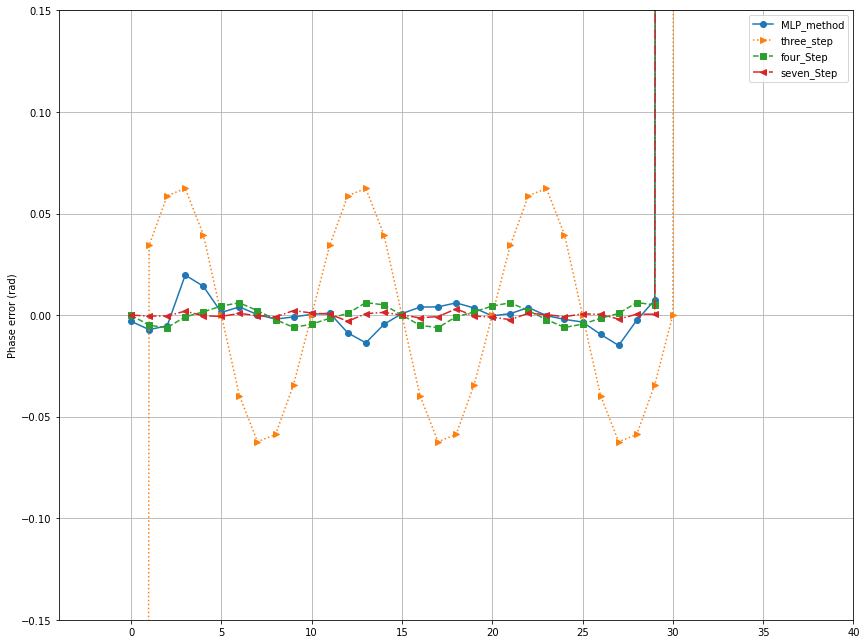

In [85]:
import torch,gc
from torch import nn
import os
import matplotlib.pyplot as plt
from MLP_net import NeuralNetwork

device = torch.device("cuda") #使用gpu进行训练
gc.collect()
torch.cuda.empty_cache()#清楚cuda缓存

def new_manner(cfg, noise_model):
    fringe_generator = fringe_wrapper(cfg, noise_model)
    fringe_images = fringe_generator.generate_all()

    phase_truth1 = fringe_generator.generate_phase()
    point_truth1 = recons3d(phase_truth1 * 0 + 88)

    # phase extraction and convert to 3d points
    # phase_measures1 = PE(cfg).basic_extract(images=fringe_images)[0]  #这里使用的是gamma谐波
    phase_measures1 = phase_wrapper(cfg,"MPSP").phase_extract(images=fringe_images)  #这里使用的是gamma谐波

    disparitys1 = (phase_measures1 - phase_truth1) * cfg.Tp[0] / (2 * np.pi) + 88
    #print(disparitys)
    point_measures1 = recons3d(disparitys1)

    # Performance evaluation
    rmse_phase1 = rmse(phase_measures1[:, 20:-20] - phase_truth1[:, 20:-20])
    rmse_point1 = rmse(dist(point_measures1[:, 20:-20, :] - point_truth1[:, 20:-20, :]))

    print("完成")
    return rmse_phase1, rmse_point1, phase_truth1, point_truth1, phase_measures1, point_measures1
    
# cfg.pattern_size = (1920, 50)
cfg.steps = [7,4,3]
# cfg.gamma=1.4
rmse_phase5, rmse_point5, phase_truth5, point_truth5, phase_measures5, point_measures5 = new_manner(cfg,noise_model)
    
print(f"RMSE(phase):{rmse_phase1}")
print(f"RMSE(point):{rmse_point1}")

# pitfall problem
# plt.figure(figsize=(12,9))
# plt.plot(phase_truth5[10,:] - phase_measures5[10,:], linetypes[4], label="MLP_method")  
# for k, p in enumerate(phase_measures4):
#     # print(phase_truth4[10,:]-p[10,:])
#     plt.plot(phase_truth4[10,:]-p[10,:], linetypes[k][:-1], label=methods[k])
# plt.ylabel("Phase error (rad)")
# plt.legend(loc=1)
# plt.grid("on")
# plt.tight_layout()
# plt.xlim(-4,40)
# plt.ylim(-0.1,0.1)
# plt.show()

# 精度问题
plt.figure(figsize=(12,9))
plt.plot(phase_truth5[10,:]-phase_measures5[10,:], linetypes[4], label="MLP_method")  
plt.plot(phase_truth1[10,:]-phase_measures1[10,:], linetypes[0], label="three_step")
plt.plot(phase_truth2[10,:]-phase_measures2[10,:], linetypes[1], label="four_Step")
plt.plot(phase_truth3[10,:]-phase_measures3[10,:], linetypes[2], label="seven_Step")
plt.ylabel("Phase error (rad)")
plt.legend(loc=1)
plt.grid("on")
plt.tight_layout()
plt.xlim(-4,40)
plt.ylim(-0.15,0.15)
plt.show()
